### CS 575 Final Project

Description and solution to the final project in CS 575 for fall semester 2025.

- Mike Goodrich
- Brigham Young University
- March 2025

---

### Prior Project

The previous project constructed the person-person network by
- constructing a knowledge graph with the following 
  - node types
    - person
    - thread
    - channel
  - edge types
    - posted in thread
    - posted in channel
    - replied to
- using one-mode projection to form the person-person network

The project then had students apply node metrics and graph partitioning metrics to find 
- influential nodes
- community structures and inter-community bridges

Given the influential nodes and community structures, students then had to 
- develop a strategy for choosing early adopters so that a complex contagion could spread on the network
- simulate the complex contagion on the network to see how well their design worked

---


### Proposed Project

The proposed project shifts from social structure to semantic structure. A different graph schema will be used so that students can build a network that connects related messages. The proposed learning objectives are

**Learning Objectives**
- Design a knowledge graph schema based on textual content.
- Apply embedding techniques to short, informal text.
- Use GNNs to embed nodes based on content and relationships.
- Interpret clusters of embedded text data.

I've worked with ChatGPT-4o to create the following specification. The rest of this notebook will elaborate and implement the specification.

1. **Build the Knowledge Graph**
  - Nodes: Messages (from edges.csv — each message is a unique edge with content).
  - Edges between messages (Students will use edges.csv and nodes.csv to map messages to threads/channels/authors.):
    - Same author
    - Same recipient
    - Same channel
    - Same thread
    - Optional: same author and receiver
    - Optional: time adjacency (within X minutes in same thread)


2. **Form "Related Message" Network**
  - Find biadjacency matrix with messages as columns
  - Use one-mode projection to form adjacency matrix for which messages are related to which other messages

3. **Extract Feature Vectors for Messages**
  - Use one of the feature extraction strategies above. These are precanned methods for extracting features that won't be taught in class.
  - The feature vector for each message node is initialized with its vector.

4. **Train a GNN to Learn Embeddings**
  - Use a simple GCN or GAT with 2–3 layers.
  - Train using unsupervised objectives (e.g., Deep Graph Infomax or contrastive loss). I propose to use _reconstruction loss_ since I'll have taught that
  - Alternatively, treat it as node classification if you can weakly label messages by topics (optional).

5. **Visualize and Cluster**
  - Project the learned node embeddings using t-SNE or UMAP.
  - Cluster using KMeans or DBSCAN.
  - Display representative messages from each cluster.

6. **Analyze**
  - What kinds of messages cluster together?
  - Do clusters correlate with authors, channels, threads?
  - How do different edge definitions affect the graph (e.g., adding reply edges vs. not)?

The remainder of this notebook will go through these steps.

---

### Build the Knowledge Graph

#### Step 1: Extract Nodes

Read the `nodes.csv` file into a pandas dataframe and inspect the header. 


In [77]:
import pandas as pd
nodes_data = pd.read_csv('cs236_data/nodes.csv')
nodes_data.head()

,node,type,value
0,530,person,TA
1,0,person,TA
2,80,person,Student
3,531,person,Student
4,162,person,Student


- The entries in the node column are unique _node IDs_
- The entries in the node column are _node types_
  - person
  - thread
  - channel
- The entries in the value column depend on the node type
  - person values are one of
    - TA
    - Student
    - Instrutor
  - channel values are one of the channels in the Discord server
    - general
    - project 1
    - etc
  - thread values are the names given to the thread which are one of the following
    - names chosen by the person initiating the thread
    - first few words from the message from which the thread spawned

We can illustrate this relationship.

<img src="figures/nodes_organization.png" alt="Hierarchical relationship among nodes in nodes.csv" width = "800">

Start building the knowledge graph by extracting three node types: person, channel, thread.  Each vertex in the graph will have three properties:
- unique vertex ID (which will not be the same as the node ID)
- vertex type
  - person
  - channel
  - thread
- vertex value
  - type of person
  - channel name
  - thread name

Read edge data and get familiar with it

In [78]:
import networkx as nx
from typing import Tuple

def add_nodes_from_node_dataframe(dataframe: pd.DataFrame,
                                  G: nx.Graph
                                  ) -> Tuple[nx.Graph, dict[int, int]]:
    """ 
        Take an empty graph and populate it with nodes.
        Inputs
          • dataframe is a pandas dataframe for node types
          • G is a graph with no edges and no nodes
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • A dictionary that allows the vertex ID in the graph to be looked up
            from node ID in the file
        Note attributes
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) > 0:
        raise ValueError("Graph must be empty")
    
    nodeID_to_vertexID: dict[int, int] = dict()

    # For each row in the nodes.csv dataframe
    for vertex_ID, row in dataframe.iterrows():
        G.add_node(vertex_ID,
                   node_ID = int(row['node']), 
                   node_type = str(row['type']),
                   node_value = str(row['value']))
        nodeID_to_vertexID[row['node']] = vertex_ID
    return G, nodeID_to_vertexID


Confirm that we are getting the node that we want. 

In [79]:
G = nx.Graph()
G, nodeID_to_vertexID = add_nodes_from_node_dataframe(nodes_data, G)
for node, attrs in G.nodes(data=True):
    print(f"node {node} has attributes: ID = {attrs.get('node_ID')}, type = {attrs.get('node_type')}, value = {attrs.get('node_value')[:2]}")
    if node > 10: 
        break

node 0 has attributes: ID = 530, type = person, value = TA
node 1 has attributes: ID = 0, type = person, value = TA
node 2 has attributes: ID = 80, type = person, value = St
node 3 has attributes: ID = 531, type = person, value = St
node 4 has attributes: ID = 162, type = person, value = St
node 5 has attributes: ID = 7, type = person, value = St
node 6 has attributes: ID = 532, type = person, value = St
node 7 has attributes: ID = 533, type = person, value = St
node 8 has attributes: ID = 534, type = person, value = St
node 9 has attributes: ID = 535, type = person, value = St
node 10 has attributes: ID = 536, type = person, value = St
node 11 has attributes: ID = 537, type = person, value = St


Look at graph to make sure things make sense

In [80]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from typing import Hashable

def show_graph(G: nx.Graph, 
               categories: list[str],
               pos: dict[Hashable, Tuple[float,float]] | None = None,
               title: str = "Graph from pandas dataframe"
               ) -> None:
    color_template: dict[str, str] = {'person': 'lightblue', 
                                    'thread': 'y', 
                                    'channel': 'salmon', 
                                    'message': 'm'}
    # Need to add error checking. That is where the categories argument will be used
    node_colors: list[str] = []
    for node in G.nodes():
        if G.nodes[node]['node_type'] == 'name':
            node_colors.append(color_template['name'])
        elif len(G.nodes[node]['node_type'].split(",")) > 1:
            node_colors.append(color_template['combo'])
        else:
            node_colors.append(color_template[G.nodes[node]['node_type']])

    plt.figure()
    #pos = nx.spring_layout(G)
    #pos = nx.nx_pydot.pydot_layout(G, prog="neato")
    if pos is None:
        pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
    nx.draw_networkx_nodes(G, pos, node_color = node_colors, alpha=0.5,node_size=20 )
    nx.draw_networkx_edges(G, pos, edge_color="lightgray", width=0.5)
    
    # create and add legend
    legend_patches = [mpatches.Patch(color=color, label=category) for category, 
                    color in color_template.items() if category in categories]
    _ = plt.legend(handles=legend_patches, title="Node Types", loc="best")

    # Add the title
    _ = plt.title(title)
    _ = plt.axis('off')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


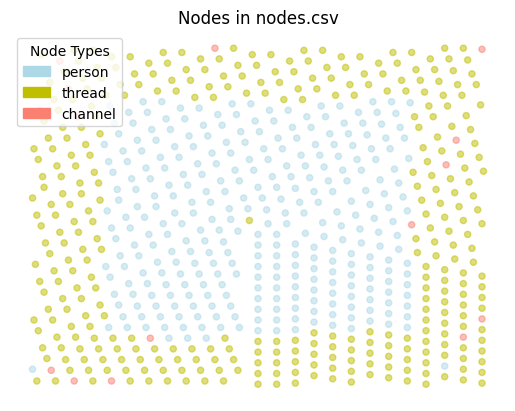

In [81]:
show_graph(G, ["person", "thread", "channel"], title = "Nodes in nodes.csv")

#### Step 2: Add Node for Each Message

Add a node for each message in `edges.csv`. The columns are
- _source_: the source of the message
- _target_: the destination of the message
- _edge type_: determined by the destimation of the message
  - `posted_in_channel` means the source is a person and the target is a channel
  - `replied_to` means the source is a person and the target is a person
  - `posted_in_thread` mens the source is a person and the target is a channel
  - `thread_in_channel` means the source is a thread and the thread is in a channel
- _content_: determined by the edge type
  - the message if the edge type is anything but `thread_in_channel`
  - empty if the edge type is `thread_in_channel`

We can illustrate this relationship.

<img src="figures/edges_organization.png" alt="Hierarchical relationship among edges in edges.csv" width = "600">

Let's confirm this pattern.

In [82]:
edges_data = pd.read_csv('cs236_data/edges.csv')
edges_data.head()

,source,target,edge_type,content
0,0,1,posted_in_channel,Project Submission Question
1,0,0,replied_to,I'm feeling better so I'll be in at around 11:30
2,0,2,replied_to,Nope
3,0,3,replied_to,Will there be any TAs today?
4,0,4,replied_to,"Yes, see the <#1148663286267641906> for specif..."


Let's now create a vertex in the graph for each message.

In [83]:
def add_nodes_from_edges_dataframe(dataframe: pd.DataFrame,
                                   G: nx.Graph,
                                   ) -> nx.Graph:
    """ 
        Take a graph populated with nodes and add a node for each message
        Inputs
          • dataframe is a pandas dataframe for node types
          • G is a graph with no edges but with nodes having the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • vertexID_to_nodeID: a dictionary that allows easy mapping from the vertex
            number used in the graph to the node ID used in the database
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
        Note attributes
          • The node ID is an int
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) == 0:
        raise ValueError("Graph must be populated with nodes before adding messages")
    
    node_value: str  # C style type declaration

    vertex_ID: int = len(G) # start counting message nodes at the end of the other nodes
    # For each row in the nodes.csv dataframe
    for index, row in dataframe.iterrows():
        if row['content'] is None:
            node_value = ""
        else:
            node_value = str(row['content'])
        G.add_node(vertex_ID + index,
                   node_ID = index, 
                   node_type = 'message',
                   node_value = node_value)
    return G

Call the function and inspect the graph. There should be a ton of message nodes

In [84]:
# We'll only include 30 fixed number of messages for now
num_messages: int = 1000
num_messages = len(edges_data)
G = add_nodes_from_edges_dataframe(edges_data.head(num_messages), G)
#pos = nx.spring_layout(G) # use spring layout because other layout will be too big
#show_graph(G, ["person", "thread", "channel", "message"], title = "All nodes")


Add edges. Since all information from `nodes.csv` is already in the graph, we only need to use information from `edges.csv`.

#### Step 3: Define Graph Schema

We must have a new graph schema when we include messages as graph vertices. 

<img src="figures/final_project_graph_schema.png" alt="Graph schema for final project with messages as graph vertices" width = "600">

The function that adds edges must implement this schema.

## TODO: 

It works best if the channel is dropped since that causes a lot of components to be complete.

#### Step 4: Add Edges According to the Schema

In [85]:
def add_edges(G: nx.Graph,
              dataframe: pd.DataFrame,
              nodeID_to_vertexID: dict[int,int]
              ) -> nx.Graph:
    """ 
        Take a graph populated with nodes and add an edge according to the Graph Schema
        Inputs
          • G is a graph with no edges but with nodes having the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
          • dataframe is a pandas dataframe for node types
          • nodeID_to_vertexID: a dictionary that allows easy mapping from the node ID used 
            in the database to the vertex ID used in the graph
        Output: 
          • A graph populated with nodes. Each node has the following attributes
            - A unique node number. The unique number is necessary to keep graphviz from crashing
            - A node_value, which is the information obtained from cell in the dataframe
            - node_type, which is the category to which the node belongs
        Note attributes
          • The node ID is an int
          • The node type is a string. 
          • The node value is a string, whose interpretation depends on the node type
    """

    # Error checks
    if len(G) == 0:
        raise ValueError("Graph must be populated with nodes before adding messages")
    

    num_nonmessage_nodes: int = len(nodeID_to_vertexID) 
    # For each row in the nodes.csv dataframe
    for index, row in dataframe.iterrows():
        source_vertex: int = nodeID_to_vertexID[row['source']]
        target_vertex: int = nodeID_to_vertexID[row['target']]
        message_vertex: int = num_nonmessage_nodes + index # Looks up message node ID
        if row['edge_type'] == 'replied_to':
            G.add_edge(source_vertex, message_vertex, edge_type = 'posted')
            G.add_edge(message_vertex, target_vertex, edge_type = 'received')
        elif row['edge_type'] == 'posted_in_channel':
            G.add_edge(source_vertex, message_vertex, edge_type = 'posted')
            G.add_edge(message_vertex, target_vertex, edge_type = 'posted_in_channel')
        elif row['edge_type'] == 'posted_in_thread':
            G.add_edge(source_vertex, message_vertex, edge_type = 'posted')
            G.add_edge(message_vertex, target_vertex, edge_type = 'posted_in_thread')
        else:
            G.add_edge(source_vertex, target_vertex, edge_type = 'thread_in_channel')
    return G

In [86]:
G = add_edges(G, edges_data.head(num_messages), nodeID_to_vertexID)
#show_graph(G, ["person", "thread", "channel", "message"], title = f"All nodes and {num_messages} messages")

Work with the largest component

In [87]:
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph with only the largest component
largest_subgraph = G.subgraph(largest_cc).copy()
show_graph(largest_subgraph, 
           ["person", "thread", "channel", "message"],
           title = f"Largest component with {num_messages} messages")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


	2197	[height=0.5,
      ^
Expected graph_stmt, found '['  (at char 557335), (line:14659, col:7)


TypeError: object of type 'NoneType' has no len()

<Figure size 640x480 with 0 Axes>

---

### Form "Related Message" Network

#### Step 1: Find Biadjacency Matrix

In [ ]:
import numpy as np
from numpy.typing import NDArray
def get_biadjacency_matrix(G: nx.Graph,
                           row_types: list[str],
                           column_types: list[str]
                           ) -> NDArray[np.float32]:
    # Error handling
    if len(row_types) == 0 or len(column_types) == 0:
        raise ValueError("Must specify node types for both row and column nodes")
    
    # Get list of nodes from each node partition
    list_0: list[Hashable] = [node for node, attrs in G.nodes(data=True) if attrs.get('node_type') in row_types] 
    if len(list_0) == 0:
        raise ValueError(f"There are no nodes in the graph with types from the row set {row_types}")
    list_1: list[Hashable] = sorted([node for node, attrs in G.nodes(data=True) if attrs.get('node_type') in column_types]) 
    if len(list_1) == 0:
        raise ValueError(f"There are no nodes in the graph with types from the column set {column_types}")


    biadjacency_matrix:NDArray = nx.bipartite.biadjacency_matrix(G, 
                                                                 row_order=list_0, 
                                                                 column_order=list_1).toarray()
    return biadjacency_matrix

In [ ]:
#B = get_biadjacency_matrix(G, ['person', 'thread', 'channel'], ['message'])
B = get_biadjacency_matrix(G, ['person','thread'], ['message'])

print(B)

[[0 0 0 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Step 2: Create Adjacency Matrix

Use one-mode projection.

In [ ]:
A = B.T@B
np.fill_diagonal(A, 0)
A[A > 1] = 1

#### Step 3: Create Graph 

The adjacency matrix can be used to create a new graph, but the graph will have lost the information about what is in the message nodes. Once we create the graph using the adjacency matrix, add the message information back into the nodes.

In [91]:
G_mm: nx.Graph = nx.from_numpy_array(A)

# Because I sorted the nodes in the "message" partition when I created the 
# biadjacency matrix, I can find a one-to-one mapping from the nodes in the
# new graph and the nodes in the old.

# Get sorted list of message nodes.
message_nodes: list[Hashable] = sorted([G.nodes[node]['node_value'] for node in G.nodes() if G.nodes[node]['node_type'] == 'message'])

print(f"There are {len(G_mm)} nodes in the new graph.")
print(f"There are {len(message_nodes)} in the old graph.")

for node_index in range(len(G_mm)):
    G_mm.nodes[node_index]['node_value'] = message_nodes[node_index]
print(f"First message is {G_mm.nodes[0]['node_value']}")

There are 1859 nodes in the new graph.
There are 1859 in the old graph.
First message is (3,1) and (1,3) are in the relation, but (3,3) is not


In [92]:
plt.figure()
pos = nx.nx_pydot.graphviz_layout(G_mm,prog="neato")
nx.draw_networkx_nodes(G_mm, pos, node_color = 'cyan', alpha=0.5,node_size=20 )
nx.draw_networkx_edges(G_mm, pos, edge_color="lightgray", width=0.5)
_ = plt.title(f"What messages are related to each other from {num_messages} messages")
_ = plt.axis('off')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


	1858	[height=0.5,
      ^
Expected graph_stmt, found '['  (at char 3335721), (line:76726, col:7)


TypeError: object of type 'NoneType' has no len()

<Figure size 640x480 with 0 Axes>

Extract largest component

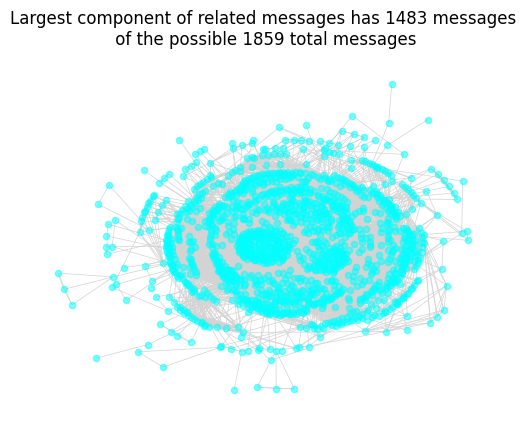

In [ ]:
largest_cc = max(nx.connected_components(G_mm), key=len)
# Create a subgraph with only the largest component
largest_subgraph_mm = G_mm.subgraph(largest_cc).copy()
nx.draw_networkx_nodes(largest_subgraph_mm, pos, node_color = 'cyan', alpha=0.5,node_size=20 )
nx.draw_networkx_edges(largest_subgraph_mm, pos, edge_color="lightgray", width=0.5)
_ = plt.title(f"Largest component of related messages has {len(largest_subgraph_mm)} messages\n of the possible {num_messages} total messages")
_ = plt.axis('off')

Show communities

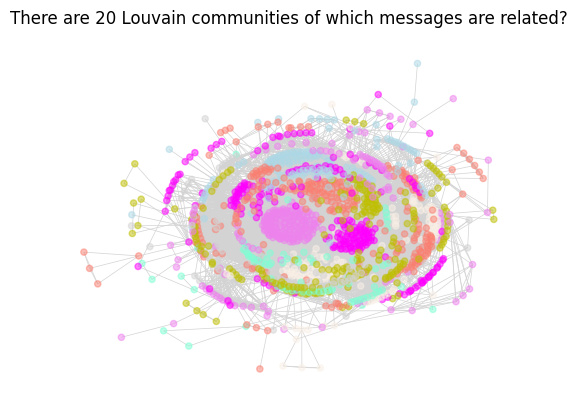

In [ ]:
partition = nx.community.louvain_communities(largest_subgraph_mm)
color_list: list[str] = ['y', 'lightblue', 'violet', 'salmon', 
                         'aquamarine', 'magenta', 'lightgray', 'linen']
node_color: list[str] = []
for node in largest_subgraph_mm:
    for i in range(len(partition)):
        if node in partition[i]: 
            node_color.append(color_list[i%len(color_list)])
            continue
nx.draw_networkx_nodes(largest_subgraph_mm, pos, node_color = node_color, alpha=0.5,node_size=20 )
nx.draw_networkx_edges(largest_subgraph_mm, pos, edge_color="lightgray", width=0.5)
_ = plt.title(f"There are {len(partition)} Louvain communities of which messages are related?")
_ = plt.axis('off')

The fact that there is a community structure suggests that we can expect local node neighborhood structure to contribute to finding a good node embedding. We'll want to augment the pure network structure with semantic information from the messages themselves.

---
---

### Extract Feature Vectors From Messages


#### Step 1: Collect Messages into Corpus


In [ ]:
message_texts: list[str] = []
for _, row in edges_data.iterrows():
    if row['content'] is not None:
        message_texts.append(str(row['content']))
for i in range(20):
    print(message_texts[i][:20])

Project Submission Q
I'm feeling better s
Nope
Will there be any TA
Yes, see the <#11486
I think I fixed all 
I will do a grade me
Zoom has issues with
Cool, I assume peopl
Up to you, I used a 
A <-> B
Is the same 
You will not be requ
This, 100%
Check the <#11468603
Yes there will be a 
The sand
Do you mean like thi
Unfortunately no, if
Shoot me a dm and we
it is also pinned in



Message Feature Vectors
To use GNNs meaningfully, each message node needs a feature vector as input. Here are a few options, ranging from simple to slightly more sophisticated — all are feasible for an introductory grad-level project.

🟩 Option 1: Bag of Words (BoW) with TF-IDF
How: Use TfidfVectorizer from sklearn on the message content.
Pros: Easy to implement, sparse but interpretable.
Cons: Doesn't capture word order or semantics.
Tip: Limit to top ~1,000 words to control dimensionality.
python
Copy
Edit
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(message_texts)  # message_texts is a list of all message strings
🟦 Option 2: Pre-trained Sentence Embeddings (e.g., SBERT, MiniLM)
How: Use a lightweight transformer model like sentence-transformers/paraphrase-MiniLM-L6-v2.
Pros: Captures semantic similarity, compact 384-dim vectors, great clustering behavior.
Cons: Slightly heavier, but still fast on CPU for ~10k messages.
python
Copy
Edit
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(message_texts, show_progress_bar=True)
🟨 Option 3: Averaged Word2Vec or GloVe
How: Use pretrained vectors, average over tokens in each message.
Pros: Lightweight, semantic.
Cons: Less accurate than SBERT for short texts; out-of-vocab problems.

In [ ]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
#X = vectorizer.fit_transform(message_texts)  # message_texts is a list of all message strings


In [ ]:
## Requires pip install sentence-tranformers

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(message_texts, show_progress_bar=True)


Batches: 100%|██████████| 59/59 [00:02<00:00, 24.73it/s]


Inspect size of embeddings.

In [ ]:
print(f"There are {len(message_texts)} messages. The embedding dimension is")
print(f"\t{embeddings.shape[0]} = number of messages by")
print(f"\t{embeddings.shape[1]} = feature vector length")
print(embeddings[0])

There are 1859 messages. The embedding dimension is
	1859 = number of messages by
	384 = feature vector length
[-0.5306829  -0.15377483 -0.15377034 -0.13081118  0.23178911 -0.05642196
 -0.43917376 -0.16602641 -0.0105789  -0.01379395 -0.11201294 -0.14992918
  0.08042608  0.2796064   0.12584515  0.31896648  0.04826517 -0.28599066
 -0.14064455  0.96018726  0.40023154  0.33234486 -0.05552095  0.03025979
  0.598942    0.29556498 -0.3564261   0.1094368  -0.20196486 -0.27227488
 -0.10187886  0.00821223 -0.5529107   0.15974621  0.49028587  0.5875236
 -0.49758202  0.01331146 -0.2946146  -0.0928584  -0.1532779  -0.1506013
 -0.07961333 -0.0103284  -0.1830392  -0.00201734 -0.24767259 -0.04495814
 -0.43813437  0.36350313 -0.1989596  -0.73206735 -0.39096022  0.17281683
 -0.04021058  0.03710829 -0.12225127 -0.3357145   0.44241858 -0.36760998
 -0.10971533 -0.3403619   0.05671537  0.6013724   0.65613467  0.04169714
 -0.48246938  0.8132235   0.03619219 -0.5060873  -0.02980914  0.12732796
 -0.70536244  0